In [1]:
import os
import nrrd
import pydicom
import numpy as np
from detect_points import detect_spheres_from_dicom
# 问题一：为什么正确的点有一个变没有点
# 问题二：要在24个方向，最少8个空间像素做投票看每个空间有几个点


[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.8.12


In [2]:
points, center_bound = detect_spheres_from_dicom(dicom_path = "C:/Users/huang/Downloads/dicom_data_bad_01", num_spheres=10)

[Taichi] Starting on arch=x64
x, y, z vote=71.0
detect vote = 112
x, y, z vote=69.0
detect vote = 117
x, y, z vote=52.0
detect vote = 96
x, y, z vote=41.0
detect vote = 57
x, y, z vote=35.0
detect vote = 66
x, y, z vote=32.0
detect vote = 63
x, y, z vote=30.0
detect vote = 54
x, y, z vote=28.0
detect vote = 43
x, y, z vote=26.0
detect vote = 45
x, y, z vote=26.0
detect vote = 52


In [ ]:
colors = [
    0xff0000, 0x00ff00, 0x0000ff, 0xffff00, 0xff00ff,
    0x00ffff, 0xff8800, 0x8888ff, 0x00aa00, 0xaa00aa
]
idx = 0
import k3d
import numpy as np

plot = k3d.plot()

# 随机生成颜色列表（RGB 0xRRGGBB）
num_spheres = points.shape[0]
colors = np.linspace(0, 0xFFFFFF, num=num_spheres, dtype=np.uint32)


# 添加边界点（与对应球心同色）
for i, (center_key, bounds) in enumerate(center_bound.items()):
    if i != 1:
        continue
    color = int(colors[i])
    if not bounds:
        continue
    bounds_np = np.array(bounds, dtype=np.float32)
    bound = center_bound[center_key]
    # print(bound)
    
    # 画圆心
    plot += k3d.points( positions=np.array([center_key], dtype=np.float32),
                    color=color, point_size=1.0,
                    shader='3d')  # 3D效果的球心点
    
    plot += k3d.text(f'id: {i}', position=center_key,
                        color=color, size=0.5, is_billboard=False)

    # 画边界
    plot += k3d.points(positions=bound,
                        color=color, point_size=0.3,
                        shader='flat')  # 边界点使用平面着色
    
    plot += k3d.text(f'{i}', position=bound,
                         color=color, size=0.5, is_billboard=True)
    

plot.display()



In [ ]:
dicom_files = []
for root, dirs, files in os.walk("C:/Users/huang/Downloads/dicom_data_bad_01"):
    for file in files:
        if file.endswith('.dcm'):
            dicom_files.append(os.path.join(root, file))
dicom_files.sort()
slices = list()
for f in dicom_files:
    try:
        ds = pydicom.dcmread(f, force=True)
        if hasattr(ds, 'pixel_array'):  # 确保文件包含像素数据
            slices.append(ds)
        else:
            print(f"⚠️ 无像素数据: {f}")
            # print(ds.pixel_array.shape)
    except Exception as e:
        print(f"❌ 读取失败: {f}, 错误: {e}")
slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
data = np.stack([s.pixel_array for s in slices])

pixel_spacing = slices[0].PixelSpacing  # x,y轴间隔
thickness = slices[0].SliceThickness    # z轴间隔

marked_data = np.zeros_like(data)

for center, bound in center_bound.items():
    x, y, z = center
    marked_data[int(z), int(y), int(x)] = 3500
    for b_x, b_y, b_z in bound:
        marked_data[int(b_x), int(b_y), int(b_z)] = 2500

    header = {
        "space": "LPS",
        "space directions": np.array(
            [[thickness, 0, 0], [0, pixel_spacing[0], 0], [0, 0, pixel_spacing[1]]]),
        "sizes": np.array([data.shape[2], data.shape[1], data.shape[0]]),
        "space origin": np.array(slices[0].ImagePositionPatient)
    }
    #
    nrrd.write('boundary_points.nrrd', marked_data, header)
    print("存储完成")
    


<Figure size 800x800 with 0 Axes>

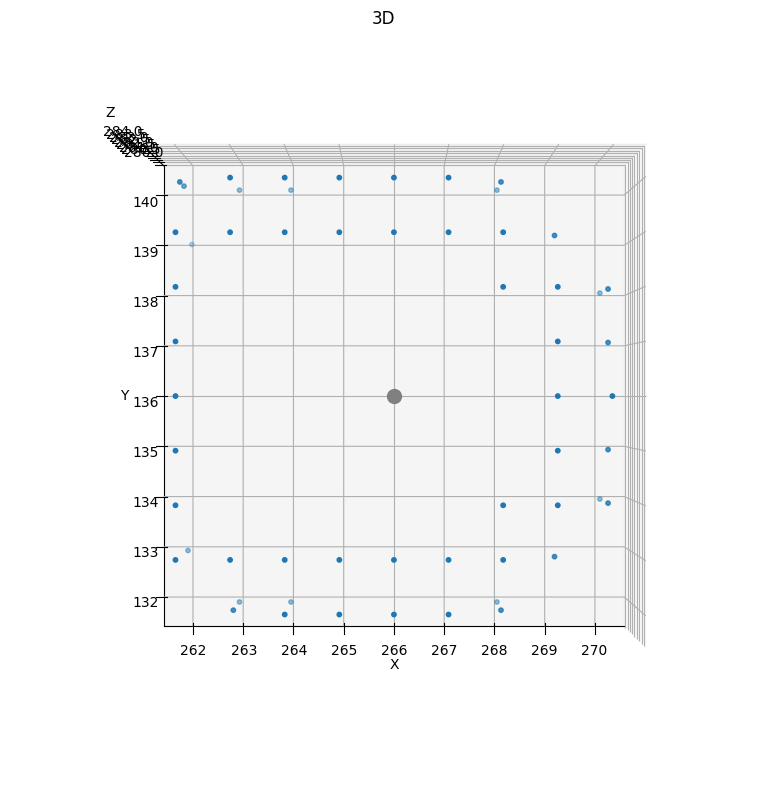

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
view = 2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for idx, ((cx, cy, cz), boundary_points) in enumerate(center_bound.items()):
    if not boundary_points:
        continue
    if (cx, cy, cz) != (280.0, 136.0, 266.0):
        continue

    bp = np.array(boundary_points)
    xs, ys, zs = bp[:, 2], bp[:, 1], bp[:, 0]

    # 画边界点
    ax.scatter(xs, ys, zs, s=10, label=f"id: {idx}")

    # 画圆心
    ax.scatter(cz, cy, cx, s=100, color='gray')
    ax.text(cx + 0.5, cy + 0.5, cz + 0.5, f'{idx}', fontsize=15, ha='center', va='center')

# 从 X 轴方向看（YZ 平面）
if view == 0:
    ax.view_init(elev=0, azim=0)  # 俯视，从正上方看
elif view == 1:
    # 从 Y 轴方向看（XZ 平面）
    ax.view_init(elev=0, azim=90)  # azim=90 表示 Y 轴方向
else:
    # 从 Z 轴方向看（XY 平面）
    ax.view_init(elev=90, azim=-90)  # azim=0 表示 X 轴方向

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D")
plt.tight_layout()
plt.show()


57


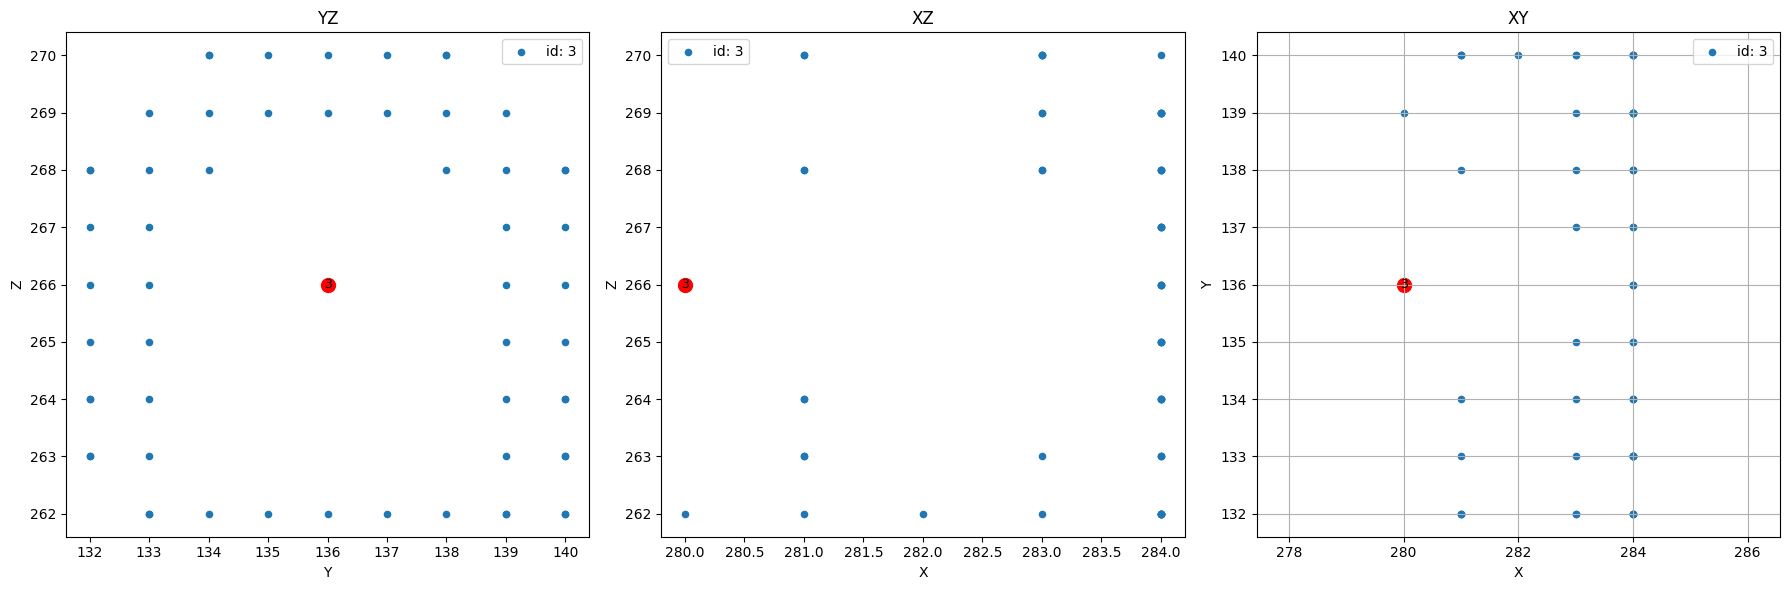

In [5]:
import matplotlib.pyplot as plt
import numpy as np


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))  # 1行2列子图

for idx, ((cx, cy, cz), boundary_points) in enumerate(center_bound.items()):
    if not boundary_points:
        continue
    if (cx, cy, cz) != (280.0, 136.0, 266.0):
        continue
    
    bp = np.array(boundary_points)
    print(len(bp))

    # ✅ 确认这是正确的 XY 顺序！（有可能你需要换成 bp[:, 2], bp[:, 1] 视情况）
    x = bp[:, 0]
    y = bp[:, 1]
    z = bp[:, 2]

    ax1.scatter(y, z, s=20, alpha=1, label=f'id: {idx}')
    # 圆心也标出来
    ax1.scatter(cy, cz, color='red', s=100, marker='o')
    ax1.text(cy, cz, f'{idx}', fontsize=9, ha='center', va='center')
    
    
    ax2.scatter(x, z, s=20, alpha=1, label=f'id: {idx}')
    # 圆心也标出来
    ax2.scatter(cx, cz, color='red', s=100, marker='o')
    ax2.text(cx, cz, f'{idx}', fontsize=9, ha='center', va='center')
    
    ax3.scatter(x, y, s=20, alpha=1, label=f'id: {idx}')
    # 圆心也标出来
    ax3.scatter(cx, cy, color='red', s=100, marker='o')
    ax3.text(cx, cy, f'{idx}', fontsize=9, ha='center', va='center')

ax1.set_title("YZ")
ax1.set_xlabel("Y")
ax1.set_ylabel("Z")
ax1.legend()
ax2.set_title("XZ")
ax2.set_xlabel("X")
ax2.set_ylabel("Z")
ax2.legend()
ax3.set_title("XY")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def count_points_in_space(center, boundary_points):
    cx, cy, cz = center
    bp = np.array(boundary_points)
    counts = [0] * 8
    for x, y, z in bp:
        region = 0
        if x > cx: region += 1
        if y > cy: region += 2
        if z > cz: region += 4
        counts[region] += 1
    return counts

In [ ]:
for center, bounds in center_bound.items():
    counts = count_points_in_space(center=center, boundary_points=bounds)
    print(counts)